as a continuation of [feature_extraction_20200523](./feature_extraction_20200523.ipynb), this notebook examines in more detail certain models, regarding convergence of recurrent computations.

as a first step, it will focus on

1. models with a high number of recurrent cycles (5,6,7)
2. models with relatively smaller cycle-to-cycle differences. "cycle-to-cycle differences" can at least be defined in two ways. I hope two definitions lead to consistent results.
    1. taking response map as a whole (N x C x D x D) and check its relative change across iterations.
    2. taking response map of each of N images, and check **average** relative change across images.

In [1]:
from os.path import dirname, relpath, realpath, join, exists

import h5py

from numpy.linalg import norm
import numpy as np

from thesis_v2 import dir_dict
from thesis_v2.submission import utils
from thesis_v2.configs.model.maskcnn_polished_with_rcnn_k_bl import (
    explored_models_20200523_gaya_feature_extraction_generator,
    script_keygen,
    keygen,
    gen_feature_extraction_global_vars
)
from json import dump, load
from os import remove
import pandas as pd

In [2]:
from thesis_v2.training.training_aux import load_training_results

In [3]:
def load_all():
    
    df_this = []
    
    batch_key='gaya/20200523'
    global_vars_for_feature_extraction = gen_feature_extraction_global_vars(key=batch_key)
    
    for idx, param_dict in enumerate(explored_models_20200523_gaya_feature_extraction_generator()):
        
        cls = param_dict['rcnn_bl_cls']
        # only examine 5, 6, 7
        if cls <= 4:
            continue
        
        key_this = script_keygen(**param_dict)        
        h5file = join(global_vars_for_feature_extraction['feature_file_dir'], key_this+'.hdf5')
        
        
        key_for_training_result = keygen(**{k: v for k, v in param_dict.items() if k not in {'scale', 'smoothness'}})
        result = load_training_results(key_for_training_result, return_model=False)
        
        cc_raw = np.asarray(result['stats_best']['stats']['test']['corr'])
        assert cc_raw.shape == (14,)
        
        auxfile = join(global_vars_for_feature_extraction['feature_file_dir'], key_this+'.json')
        assert exists(auxfile)
        auxfile2 = join(global_vars_for_feature_extraction['feature_file_dir'], key_this +'.per_image.json')
        assert exists(auxfile2)
                
        with open(auxfile, 'rt', encoding='utf-8') as f_aux:
            aux_obj = load(f_aux)
            
        with open(auxfile2, 'rt', encoding='utf-8') as f_aux2:
            aux_obj2 = load(f_aux2)
        
        if idx % 100 == 0:
            print(idx)
#             print(aux_obj)
#             print(aux_obj2)


        assert param_dict['kernel_size_l23'] == 3
        assert len(param_dict) == 24
        
        assert param_dict['kernel_size_l1'] == 9
        assert param_dict['ff_1st_block']
        assert param_dict['dataset_prefix'] == 'gaya'
        
        
        
        assert param_dict['split_seed'] == 'legacy'
        assert param_dict['pooling_ksize'] == 3
        assert param_dict['pooling_type'] == 'avg'
        assert not param_dict['bn_after_fc']
        assert param_dict['rcnn_bl_psize'] == 1
        assert param_dict['rcnn_bl_ptype'] is None
        assert param_dict['input_size'] == 63
        assert param_dict['rcnn_acc_type'] == 'cummean'

        assert param_dict['train_keep'] in {3800, 1900, 1900//2}

        index_base = {
            'train_keep': param_dict['train_keep'],
            'act_fn': param_dict['act_fn'],
            'loss_type': param_dict['loss_type'],
            'scale': float(param_dict['scale']),
            'smoothness': float(param_dict['smoothness']),
            'num_layer': param_dict['num_layer'],
            'out_channel': param_dict['out_channel'],
            # 4 to go.
            '1st_bn_before_act': param_dict['ff_1st_bn_before_act'],
            'rcnn_bl_cls': param_dict['rcnn_bl_cls'],

            'model_seed': param_dict['model_seed'],
        }
        
            
        df_this.append({**index_base, **{
            'acc_mode': 'instant',
            'diff_overall': aux_obj['test']['diff_bl_stack_instant'],
            'diff_per_image_mean': aux_obj2['test']['diff_bl_stack_instant']['mean'],
            'diff_per_image_std': aux_obj2['test']['diff_bl_stack_instant']['std'],
            'corr_test': ((cc_raw)**2).mean(),
            'h5file': h5file,
        }})
        
        df_this.append({**index_base, **{
            'acc_mode': 'cummean',
            'diff_overall': aux_obj['test']['diff_bl_stack_cummean'],
            'diff_per_image_mean': aux_obj2['test']['diff_bl_stack_cummean']['mean'],
            'diff_per_image_std': aux_obj2['test']['diff_bl_stack_cummean']['std'],
            'corr_test': ((cc_raw)**2).mean(),
            'h5file': h5file,
        }})
    
    index_keys = list(index_base.keys()) + ['acc_mode',]
    
    df_this = pd.DataFrame(
        data=df_this,
        columns=index_keys + ['diff_overall', 'diff_per_image_mean', 'diff_per_image_std', 'corr_test', 'h5file']
    ).set_index(keys=index_keys, verify_integrity=True)
    return df_this
df_all = load_all()

1200
1300
1400
1500
1600
1700
1800
1900
2000


In [4]:
df_all_cp = df_all.copy(deep=True)

In [5]:
df_all_cp['mean_diff_overall'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_overall']))
df_all_cp['mean_diff_per_image'] = df_all.apply(axis=1, func=lambda x: np.nanmean(x['diff_per_image_mean']))
df_all_cp['mean_diff_overall_first4'] = df_all.apply(axis=1, func=lambda x: np.mean(x['diff_overall'][:4]))

In [6]:
from scipy.stats import pearsonr

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

In [8]:
# let's try to quickly eliminate bad configs, just like before, by plotting scatter plots.
def scatter(x, y, xlabel, ylabel, title):
    assert x.shape == y.shape == (x.size,)
    plt.close('all')
    plt.figure(figsize=(6, 5))
    plt.scatter(x, y, s=1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.plot([0,1],[0,1],linestyle='--')
    plt.title(title)
    plt.show()
    print('N', x.size)
    print('x mean', x.mean(), 'std', x.std())
    print('y mean', y.mean(), 'std', y.std())
#     print('y-x mean', (y-x).mean(), 'y-x>0 mean', ((y-x)>0).mean())
#     print('y top', y.max(), 'x top', x.max())

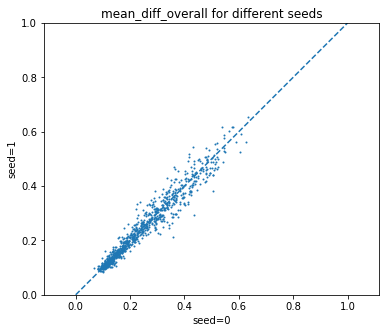

N 864
x mean 0.24622602404575267 std 0.12292901848172791
y mean 0.2463846587182172 std 0.12223696553843738
(0.971833646920446, 0.0)


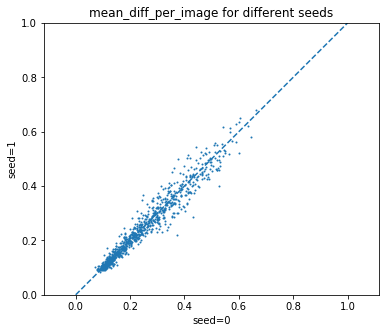

N 864
x mean 0.24932706403601276 std 0.12525329569882754
y mean 0.2494522953718474 std 0.12461433959627087
(0.9721255695756975, 0.0)


In [9]:
# almost the same.
def check_similarity_across_seeds():
    
    val = df_all_cp.unstack('model_seed').loc[:,'mean_diff_overall'].values
    scatter(val[:,0], val[:,1], 'seed=0', 'seed=1', 'mean_diff_overall for different seeds')
    print(pearsonr(val[:,0], val[:,1]))
    
    
    val = df_all_cp.unstack('model_seed').loc[:,'mean_diff_per_image'].values
    scatter(val[:,0], val[:,1], 'seed=0', 'seed=1', 'mean_diff_per_image for different seeds')
    print(pearsonr(val[:,0], val[:,1]))
    
check_similarity_across_seeds()

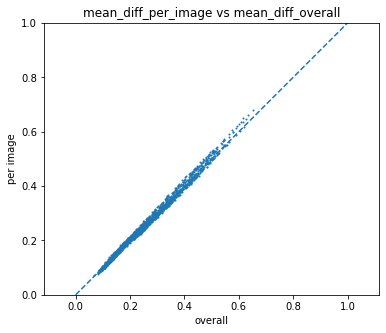

N 1728
x mean 0.24630534138198495 std 0.1225835060507852
y mean 0.24938967970393003 std 0.12493424181919942
(0.9974945347380259, 0.0)


In [10]:
# check consistency between mean_diff_overall and mean_diff_per_image

def check_consistency_between_diff_overall_and_per_image():
    
    val1 = df_all_cp['mean_diff_overall'].values
    val2 = df_all_cp['mean_diff_per_image'].values
    scatter(val1, val2, 'overall', 'per image', 'mean_diff_per_image vs mean_diff_overall')
    print(pearsonr(val1, val2))
    
# almost the same.
check_consistency_between_diff_overall_and_per_image()

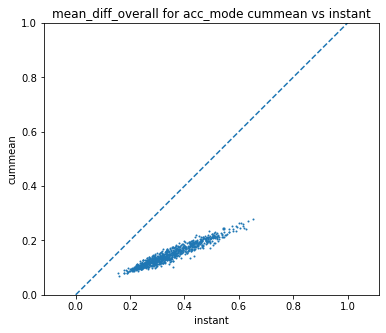

N 864
x mean 0.3449412866866354 std 0.09511410553119251
y mean 0.14766939607733445 std 0.03935275629638869
(0.9582420099846296, 0.0)


In [11]:
def check_consistency_between_instant_and_cummean():
    
    val1 = df_all_cp['mean_diff_overall'].xs('instant', level='acc_mode').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs('cummean', level='acc_mode').sort_index()
    assert val1.index.equals(val2.index)
    scatter(val1.values, val2.values, 'instant', 'cummean', 'mean_diff_overall for acc_mode cummean vs instant')
    print(pearsonr(val1.values, val2.values))
    
# pretty consistent. let's use cummean for prettier results
check_consistency_between_instant_and_cummean()

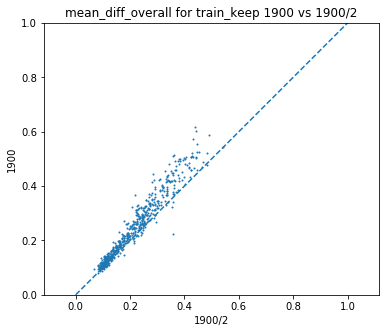

N 576
x mean 0.21354903044066978 std 0.09870191520697719
y mean 0.24700808506502112 std 0.12062204778535655
(0.9707151253647543, 0.0)


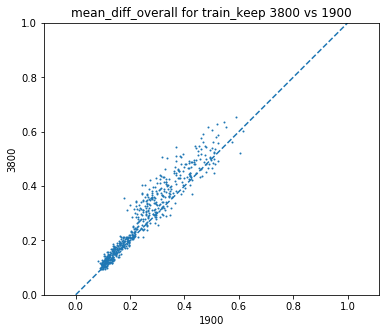

N 576
x mean 0.24700808506502112 std 0.12062204778535655
y mean 0.2783589086402639 std 0.13670223282924585
(0.9598421241888798, 4.8942e-319)


In [12]:
# check relationship to training size
def check_diff_overall_over_train_keep():
    
    val1 = df_all_cp['mean_diff_overall'].xs(1900//2, level='train_keep').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs(1900, level='train_keep').sort_index()
    val3 = df_all_cp['mean_diff_overall'].xs(3800, level='train_keep').sort_index()
    assert val1.index.equals(val2.index)
    assert val1.index.equals(val3.index)
    scatter(val1.values, val2.values, '1900/2', '1900', 'mean_diff_overall for train_keep 1900 vs 1900/2')
    print(pearsonr(val1.values, val2.values))
    
    scatter(val2.values, val3.values, '1900', '3800', 'mean_diff_overall for train_keep 3800 vs 1900')
    print(pearsonr(val2.values, val3.values))
    
check_diff_overall_over_train_keep()
# with more training data, somehow there is higher flucuation. however, it's mostly consistent.

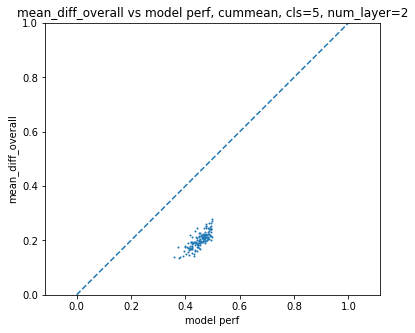

N 144
x mean 0.4530395051111015 std 0.02947193713034878
y mean 0.20229086447377792 std 0.028840083605266558
(0.7770202138387086, 2.4414600283457237e-30)


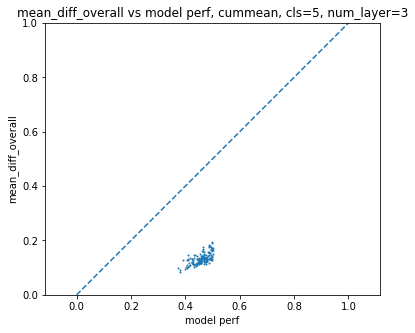

N 144
x mean 0.45841565206344626 std 0.02909615805931616
y mean 0.13340207907862756 std 0.020274296807213623
(0.650216293714168, 1.1564301191813733e-18)


In [13]:
def check_relationship_between_diff_and_performance(*, num_layer, cls):
    val1 = df_all_cp['corr_test'].xs('cummean', level='acc_mode').xs(cls, level='rcnn_bl_cls').xs(num_layer, level='num_layer').sort_index()
    val2 = df_all_cp['mean_diff_overall'].xs('cummean', level='acc_mode').xs(cls, level='rcnn_bl_cls').xs(num_layer, level='num_layer').sort_index()
    assert val1.index.equals(val2.index)
    scatter(val1.values, val2.values, 'model perf', 'mean_diff_overall', f'mean_diff_overall vs model perf, cummean, cls={cls}, num_layer={num_layer}')
    print(pearsonr(val1.values, val2.values))
    
check_relationship_between_diff_and_performance(num_layer=2, cls=5)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=5)

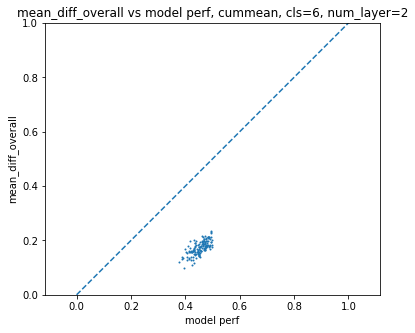

N 144
x mean 0.4530941970658968 std 0.027771232128487425
y mean 0.17362942987432084 std 0.025589702513375178
(0.7074921641855292, 3.677746973970954e-23)


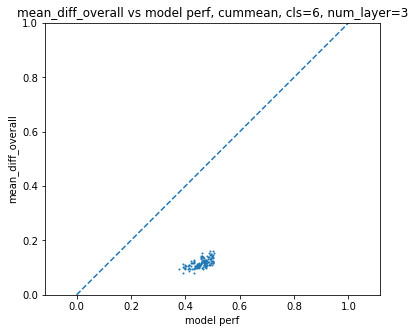

N 144
x mean 0.45863487618159887 std 0.029504270448594248
y mean 0.11742219439604216 std 0.01631642350497
(0.6216126101410507, 9.259621276190567e-17)


In [14]:
check_relationship_between_diff_and_performance(num_layer=2, cls=6)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=6)

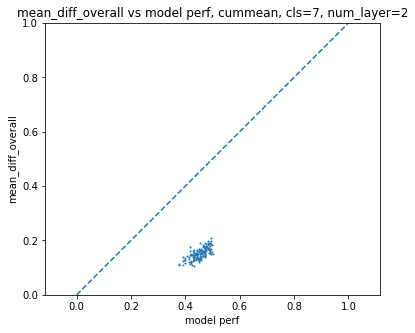

N 144
x mean 0.45265858250557006 std 0.02785205927789334
y mean 0.15280109399463981 std 0.02109232900540933
(0.7056008012168584, 5.386123354414012e-23)


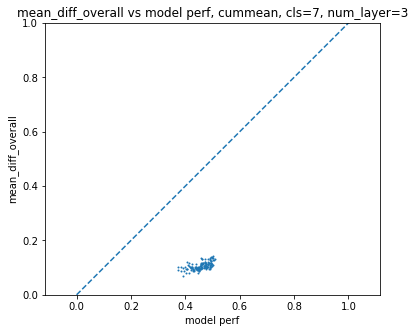

N 144
x mean 0.45737667320721953 std 0.031145649574275815
y mean 0.10647071464659853 std 0.013548090574045484
(0.5784277429317919, 3.139374264551369e-14)


In [15]:
check_relationship_between_diff_and_performance(num_layer=2, cls=7)
# having one additional layer can make output more stable.
check_relationship_between_diff_and_performance(num_layer=3, cls=7)

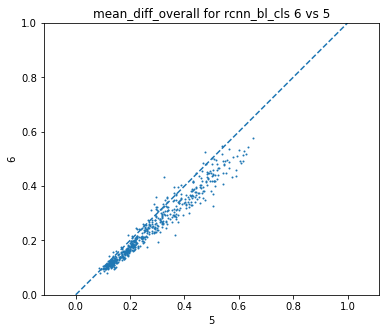

N 576
x mean 0.27643526053482975 std 0.13443586551033052
y mean 0.24295694047015987 std 0.11826014863860553
(0.9759347684891908, 0.0)


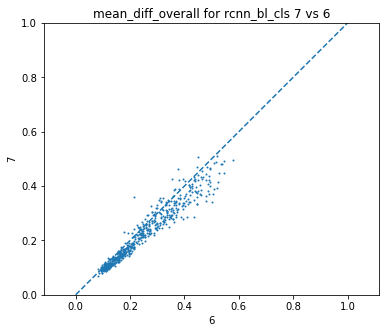

N 576
x mean 0.24295694047015987 std 0.11826014863860553
y mean 0.21952382314096516 std 0.10670243502120547
(0.9680478107244281, 0.0)


In [16]:
# relationship with cls
def check_diff_overall_over_cls(first4=False):
    field_to_check = 'mean_diff_overall' if not first4 else 'mean_diff_overall_first4'
    val1 = df_all_cp[field_to_check].xs(5, level='rcnn_bl_cls').sort_index()
    val2 = df_all_cp[field_to_check].xs(6, level='rcnn_bl_cls').sort_index()
    val3 = df_all_cp[field_to_check].xs(7, level='rcnn_bl_cls').sort_index()
    assert val1.index.equals(val2.index)
    assert val1.index.equals(val3.index)
    scatter(val1.values, val2.values, '5', '6', f'{field_to_check} for rcnn_bl_cls 6 vs 5')
    print(pearsonr(val1.values, val2.values))
    
    scatter(val2.values, val3.values, '6', '7', f'{field_to_check} for rcnn_bl_cls 7 vs 6')
    print(pearsonr(val2.values, val3.values))
    
check_diff_overall_over_cls()
# with more training data, somehow there is higher flucuation. however, it's mostly consistent.

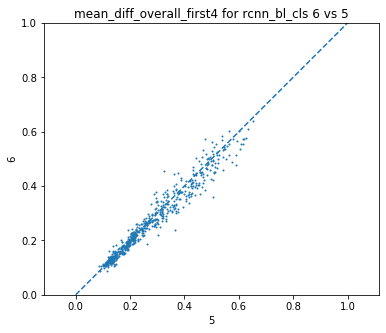

N 576
x mean 0.27643526053482975 std 0.13443586551033052
y mean 0.26945887861398254 std 0.12931472477225767
(0.9774025186201245, 0.0)


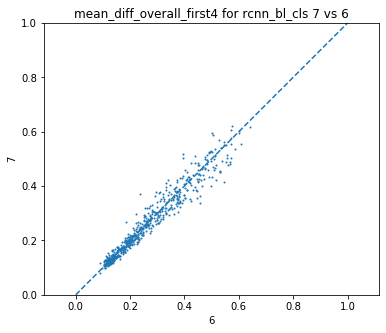

N 576
x mean 0.26945887861398254 std 0.12931472477225767
y mean 0.2674763974355301 std 0.12644132758906818
(0.972932123895076, 0.0)


In [17]:
# always take time to drop. running more iterations won't make convergence quicker.
check_diff_overall_over_cls(True)

In [18]:
# so, let's study cls=7, cummean models

# which training size? study both 1280 and 5120

# maybe do a mean pooling first, to make vector shorter. also, the pooling version is what's actually used in fully connected layer.
from torch.nn.functional import avg_pool2d
import torch
def transform_data_all_epochs(tensor_list):
    for z in tensor_list:
        assert z.ndim == 4
#         print(z.shape)
    pooled_version = [avg_pool2d(torch.tensor(x), kernel_size=3).numpy() for x in tensor_list]
#     for zz in pooled_version:
# #         print(zz.shape)
        
    # then reshape . just concatenate them to do PCA/tSNE, etc.
    return [x.reshape(x.shape[0], -1) for x in pooled_version]


In [19]:
df_all_cp_to_study = df_all_cp.xs(0, level='model_seed').xs(7, level='rcnn_bl_cls').xs('cummean', level='acc_mode')

In [20]:
df_all_cp_to_study.iloc[0]

diff_overall                [0.31052646040916443, 0.14843036234378815, 0.0...
diff_per_image_mean         [0.323091214739141, 0.15712236092913717, 0.102...
diff_per_image_std          [0.07153921269667934, 0.036982031373582955, 0....
corr_test                                                            0.395944
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.129175
mean_diff_per_image                                                  0.136616
mean_diff_overall_first4                                             0.158232
Name: (950, relu, mse, 0.01, 5e-06, 2, 8, True), dtype: object

In [21]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [22]:
# def show_data_for_one(data_this):
#     # load h5file,
#     # compute mean version
#     # get pooled & reshaped version.
#     cls = 7
#     print(data_this)
#     with h5py.File(data_this['h5file'], 'r') as f:
#         g = f['test']
#         tensor_list = [g[f'0.{x}'][()] for x in range(cls)]
#     tensor_list_new = []
#     for i in range(len(tensor_list)):
#         tensor_list_new.append(np.mean(np.asarray(tensor_list[:i+1]), axis=0))
#     tensor_list = tensor_list_new
#     tensor_list = transform_data_all_epochs(tensor_list)
    
#     # then concat them
#     data_all_epochs = np.concatenate(tensor_list, axis=0)
#     print(data_all_epochs.shape)
#     # then do PCA
    
#     # not useful, because only <15% of data explained in first two dims.
    
# #     pca_obj = PCA(n_components=2, svd_solver='full')
# #     data_all_epochs_pca = pca_obj.fit_transform(data_all_epochs)
# #     print(data_all_epochs_pca.shape)
# #     print(pca_obj.explained_variance_ratio_)
    
#     # try TSNE
    
#     tsne_obj = TSNE(n_components = 2, random_state=0, n_jobs=-1)
#     data_all_epochs_tsne = tsne_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_tsne.shape)
#     return data_all_epochs_tsne

In [23]:
def show_data_for_one_pca(data_this, img_idx):
    # load h5file,
    # compute mean version
    # get pooled & reshaped version.
    cls = 7
#     print(data_this)
    with h5py.File(data_this['h5file'], 'r') as f:
        g = f['test']
        tensor_list = [g[f'0.{x}'][img_idx:img_idx+1,] for x in range(cls)]
    tensor_list_new = []
    for i in range(len(tensor_list)):
        tensor_list_new.append(np.mean(np.asarray(tensor_list[:i+1]), axis=0))
    tensor_list = tensor_list_new
    tensor_list = transform_data_all_epochs(tensor_list)
    
    # then concat them
    data_all_epochs = np.concatenate(tensor_list, axis=0)
#     print(data_all_epochs.shape)
    # then do PCA
    
    # not useful, because only <15% of data explained in first two dims.
    
    pca_obj = PCA(n_components=2, svd_solver='full')
    data_all_epochs_pca = pca_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_pca.shape)
#     print(pca_obj.explained_variance_ratio_)
    return {
        'pca': data_all_epochs_pca,
        'var_ratio': tuple(pca_obj.explained_variance_ratio_.tolist()),
    }
#     # try TSNE
    
#     tsne_obj = TSNE(n_components = 2, random_state=0, n_jobs=-1)
#     data_all_epochs_tsne = tsne_obj.fit_transform(data_all_epochs)
#     print(data_all_epochs_tsne.shape)
#     return data_all_epochs_tsne

In [24]:
df_all_cp_to_study_sorted = df_all_cp_to_study.sort_values(by='corr_test', ascending=False)

In [25]:
# data_tsne = show_data_for_one(df_all_cp_to_study_sorted.iloc[0])

In [26]:
import matplotlib

cmap = matplotlib.cm.get_cmap('tab20')

colors_to_use = cmap.colors

In [27]:
# 

In [28]:
def plot_25_graph_given_data(data_this, seed):
    print(data_this)
    plt.close('all')
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
    axes = axes.ravel()
    
    rng_state = np.random.RandomState(seed=seed)
    images_to_take =  rng_state.choice(1050, 25)
    assert len(axes) == len(images_to_take) == 25
    for img_idx, ax in zip(images_to_take, axes):
        # get pca
        pca_this = show_data_for_one_pca(data_this, img_idx)
        varratio = '{:.2f},{:.2f}'.format(pca_this['var_ratio'][0], pca_this['var_ratio'][1])
        ax.set_title(f"img {img_idx}, pca {varratio}")
        
        # plot.
        pca_xy = pca_this['pca']
        
        for idx_cls in range(pca_xy.shape[0]-1):
            xy = pca_xy[idx_cls]
            xydelta = pca_xy[idx_cls+1]-pca_xy[idx_cls]
            ax.arrow(*xy, *xydelta, head_width=1)
            
        ax.axis('equal')
        ax.set_xlim(pca_xy.min()-1, pca_xy.max()+1)
        ax.set_ylim(pca_xy.min()-1, pca_xy.max()+1)
    plt.show()

diff_overall                [0.290233314037323, 0.16729001700878143, 0.117...
diff_per_image_mean         [0.28043923497200013, 0.1633869889165674, 0.11...
diff_per_image_std          [0.0423735430092294, 0.020969511755845365, 0.0...
corr_test                                                            0.507695
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.133465
mean_diff_per_image                                                  0.130357
mean_diff_overall_first4                                             0.166386
Name: (3800, softplus, poisson, 0.01, 5e-06, 3, 32, False), dtype: object


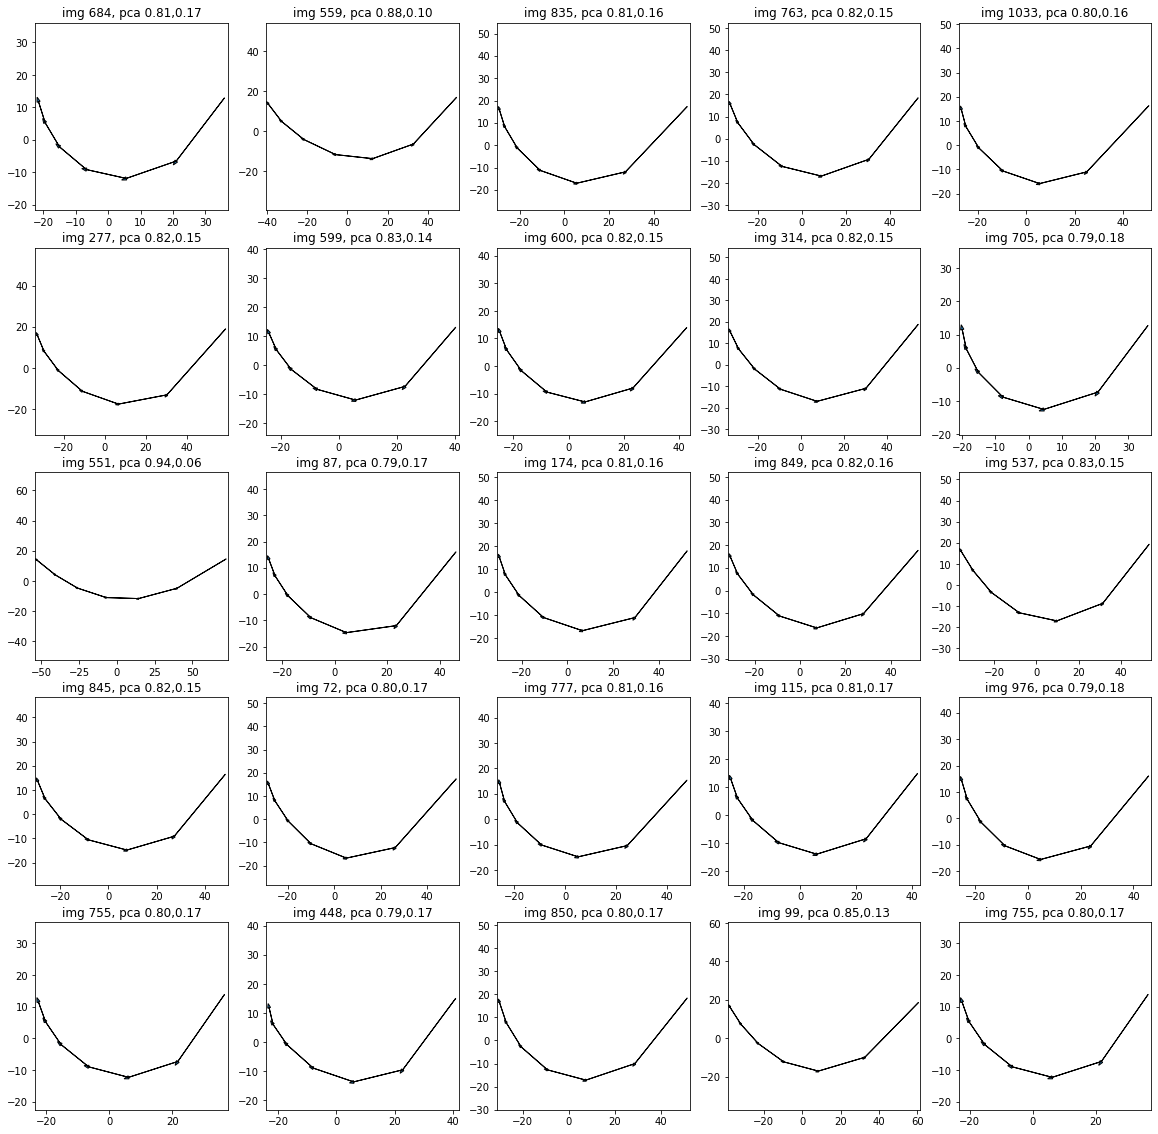

In [29]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 0)

diff_overall                [0.290233314037323, 0.16729001700878143, 0.117...
diff_per_image_mean         [0.28043923497200013, 0.1633869889165674, 0.11...
diff_per_image_std          [0.0423735430092294, 0.020969511755845365, 0.0...
corr_test                                                            0.507695
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.133465
mean_diff_per_image                                                  0.130357
mean_diff_overall_first4                                             0.166386
Name: (3800, softplus, poisson, 0.01, 5e-06, 3, 32, False), dtype: object


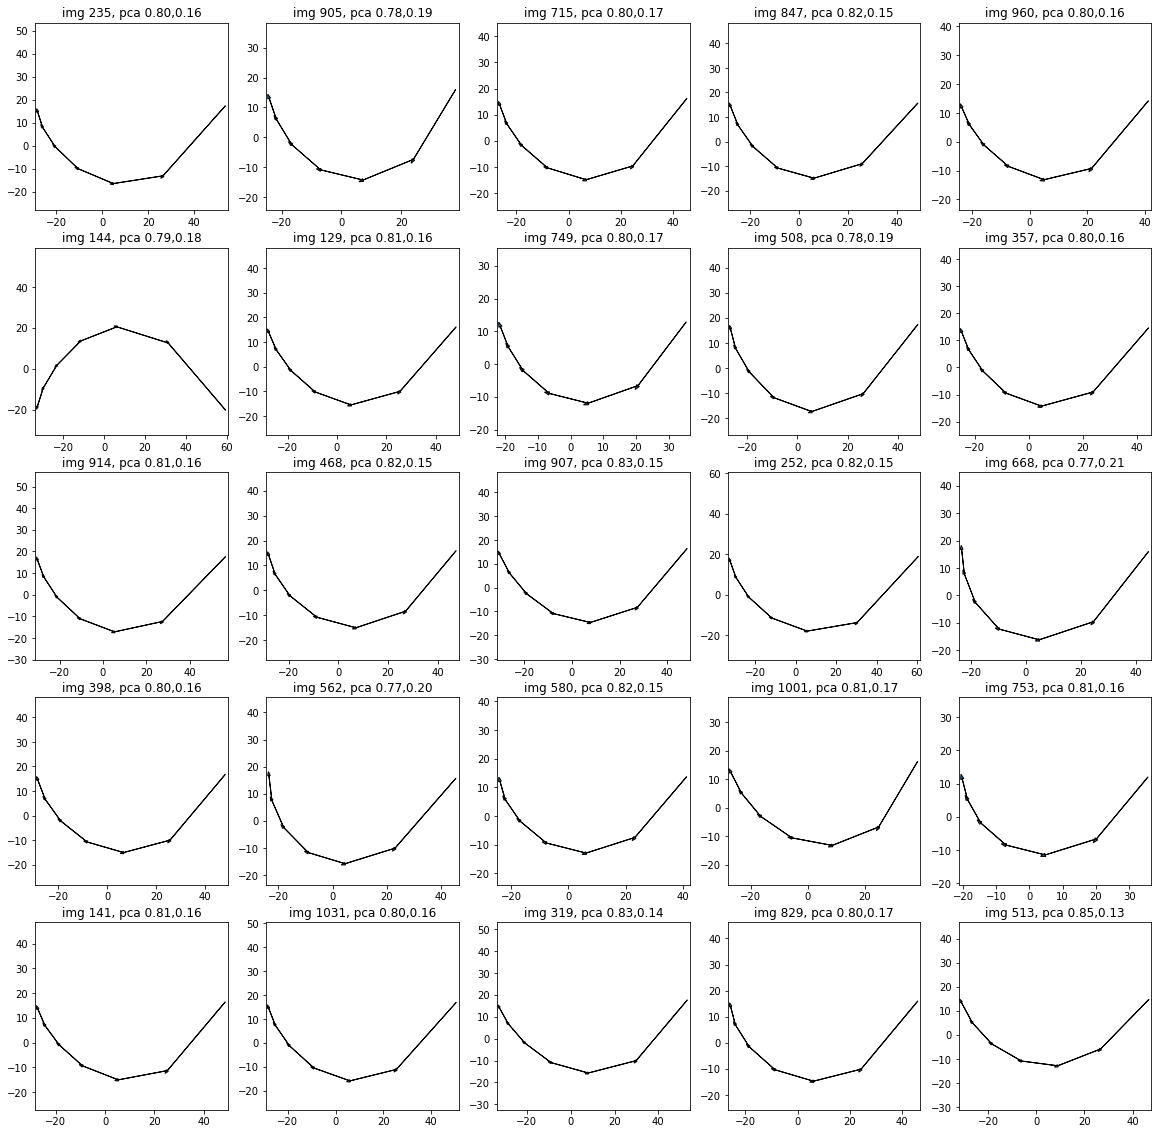

In [30]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 1)

diff_overall                [0.290233314037323, 0.16729001700878143, 0.117...
diff_per_image_mean         [0.28043923497200013, 0.1633869889165674, 0.11...
diff_per_image_std          [0.0423735430092294, 0.020969511755845365, 0.0...
corr_test                                                            0.507695
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.133465
mean_diff_per_image                                                  0.130357
mean_diff_overall_first4                                             0.166386
Name: (3800, softplus, poisson, 0.01, 5e-06, 3, 32, False), dtype: object


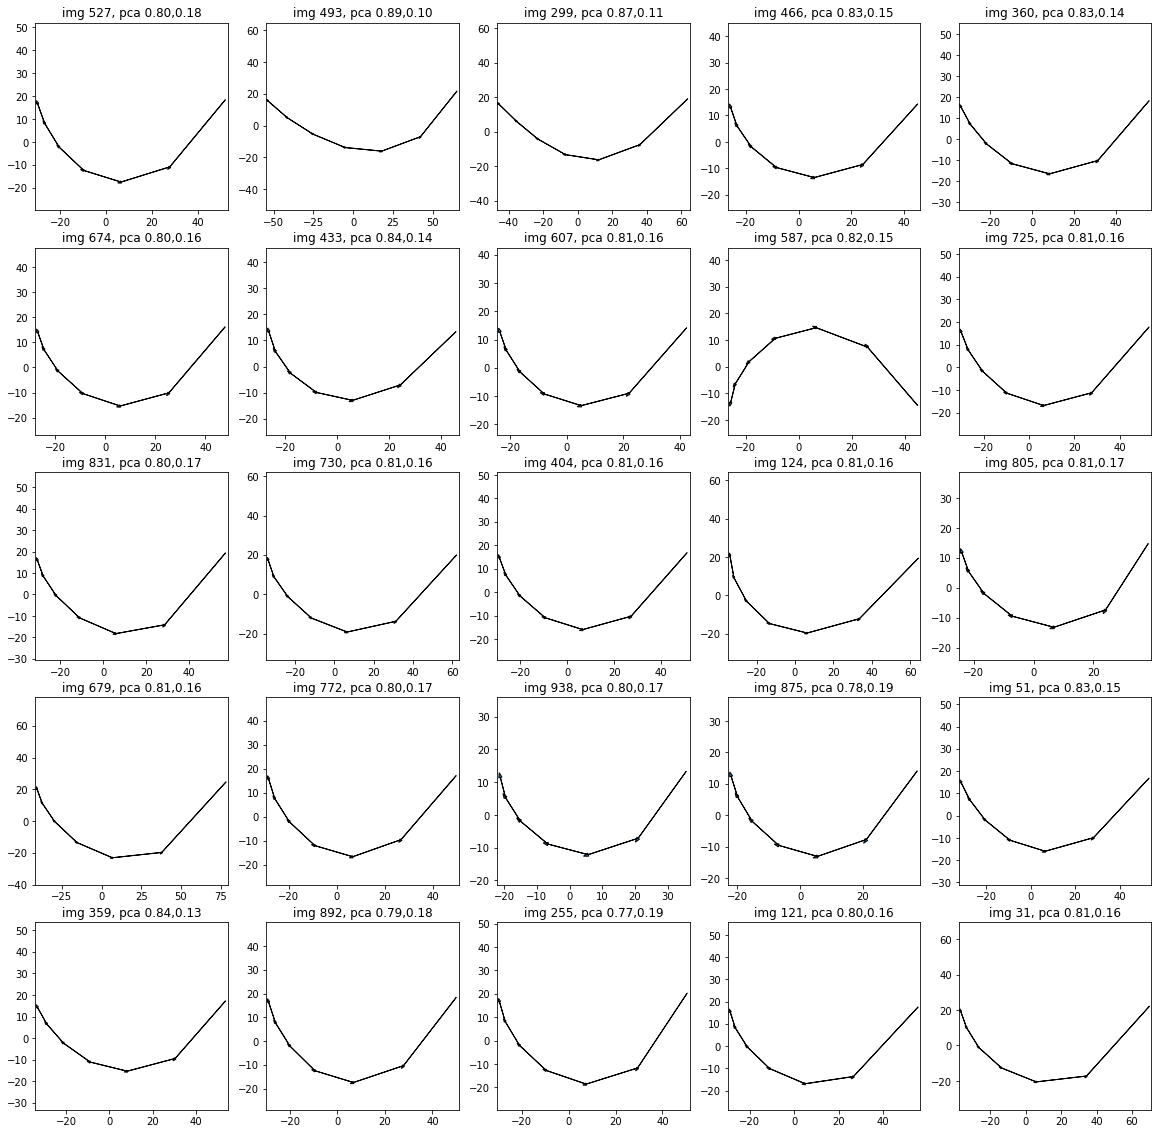

In [31]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[0], 2)

diff_overall                [0.24757342040538788, 0.11850600689649582, 0.0...
diff_per_image_mean         [0.2539012766593979, 0.12220463163795925, 0.08...
diff_per_image_std          [0.03883335664295921, 0.020318596658313898, 0....
corr_test                                                            0.372763
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.100825
mean_diff_per_image                                                  0.103367
mean_diff_overall_first4                                              0.12693
Name: (950, relu, poisson, 0.01, 5e-06, 3, 16, False), dtype: object


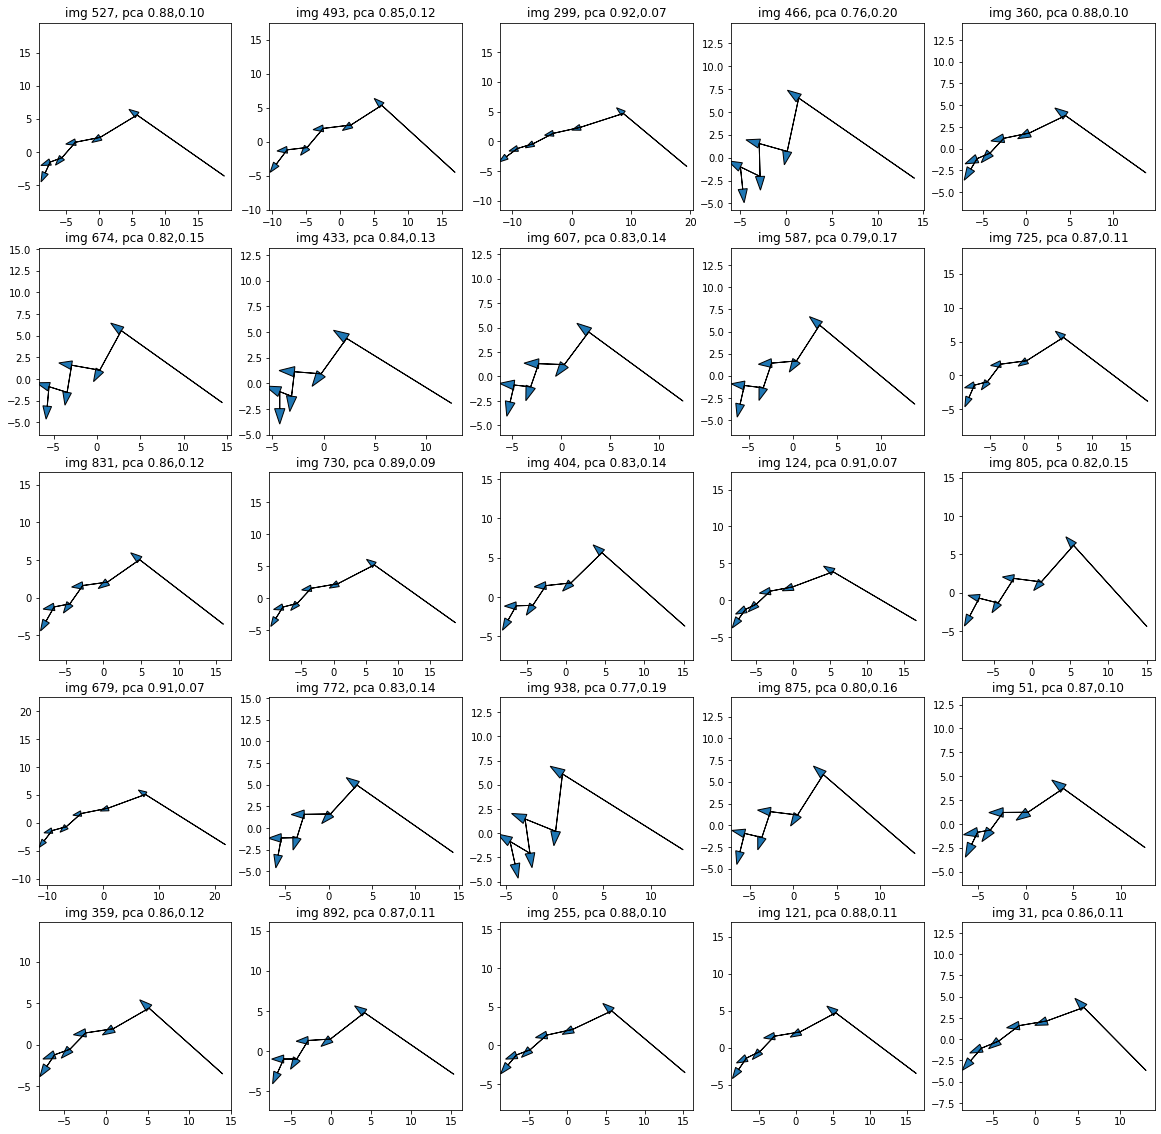

In [32]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], 2)

diff_overall                [0.24757342040538788, 0.11850600689649582, 0.0...
diff_per_image_mean         [0.2539012766593979, 0.12220463163795925, 0.08...
diff_per_image_std          [0.03883335664295921, 0.020318596658313898, 0....
corr_test                                                            0.372763
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                    0.100825
mean_diff_per_image                                                  0.103367
mean_diff_overall_first4                                              0.12693
Name: (950, relu, poisson, 0.01, 5e-06, 3, 16, False), dtype: object


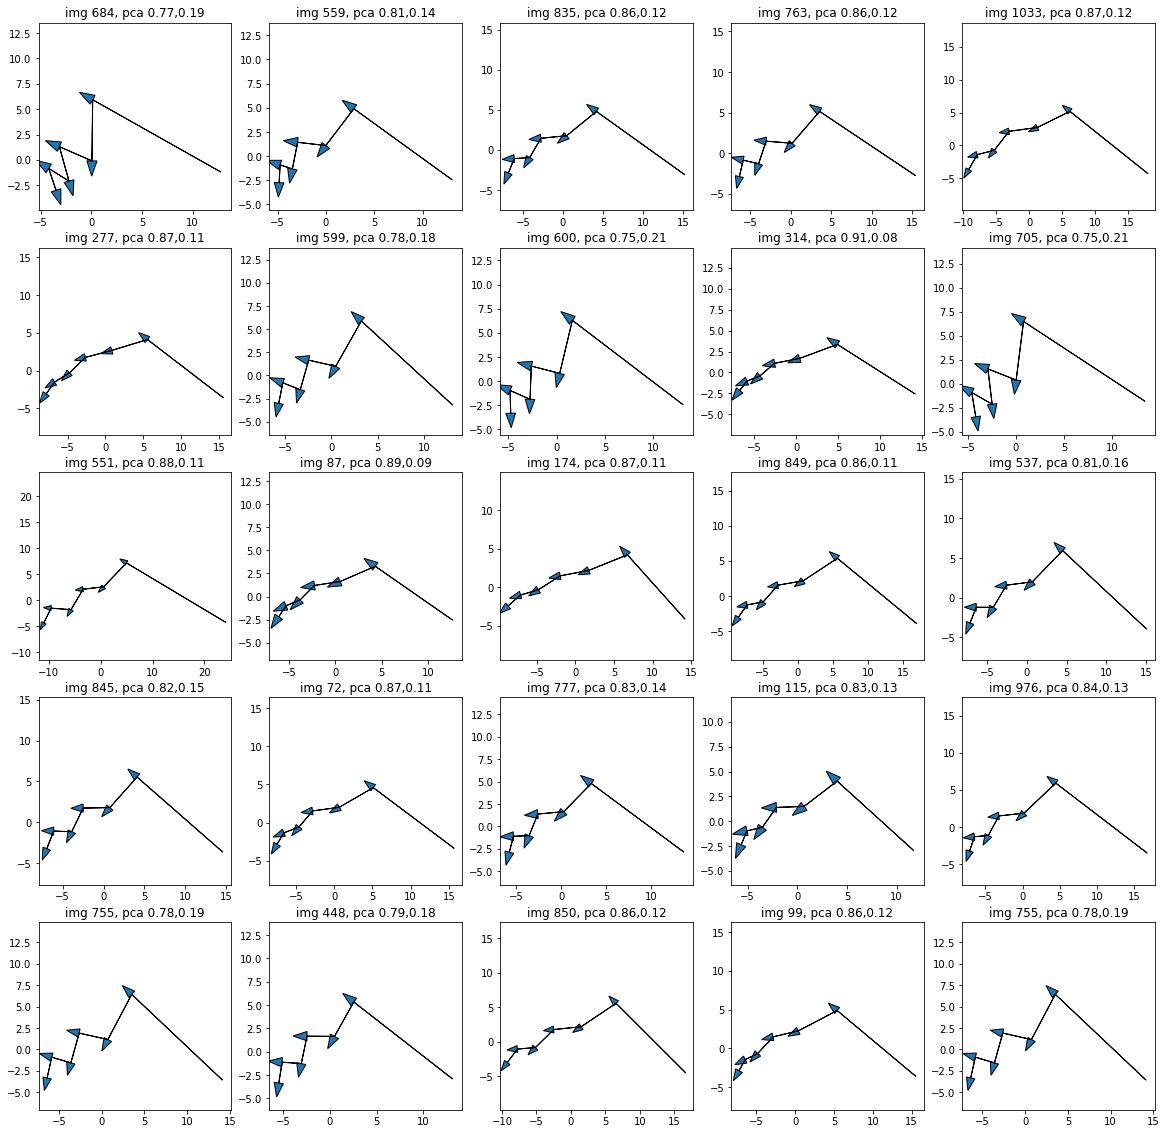

In [33]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-1], 0)

diff_overall                [0.20852486789226532, 0.09927666932344437, 0.0...
diff_per_image_mean         [0.21105647772550584, 0.10262517961362998, 0.0...
diff_per_image_std          [0.021218348819011135, 0.02055348505559273, 0....
corr_test                                                            0.373508
h5file                      /my_data/thesis-yimeng-v2/results/features/mas...
mean_diff_overall                                                   0.0902746
mean_diff_per_image                                                 0.0924774
mean_diff_overall_first4                                             0.109651
Name: (950, relu, poisson, 0.01, 5e-06, 3, 8, True), dtype: object


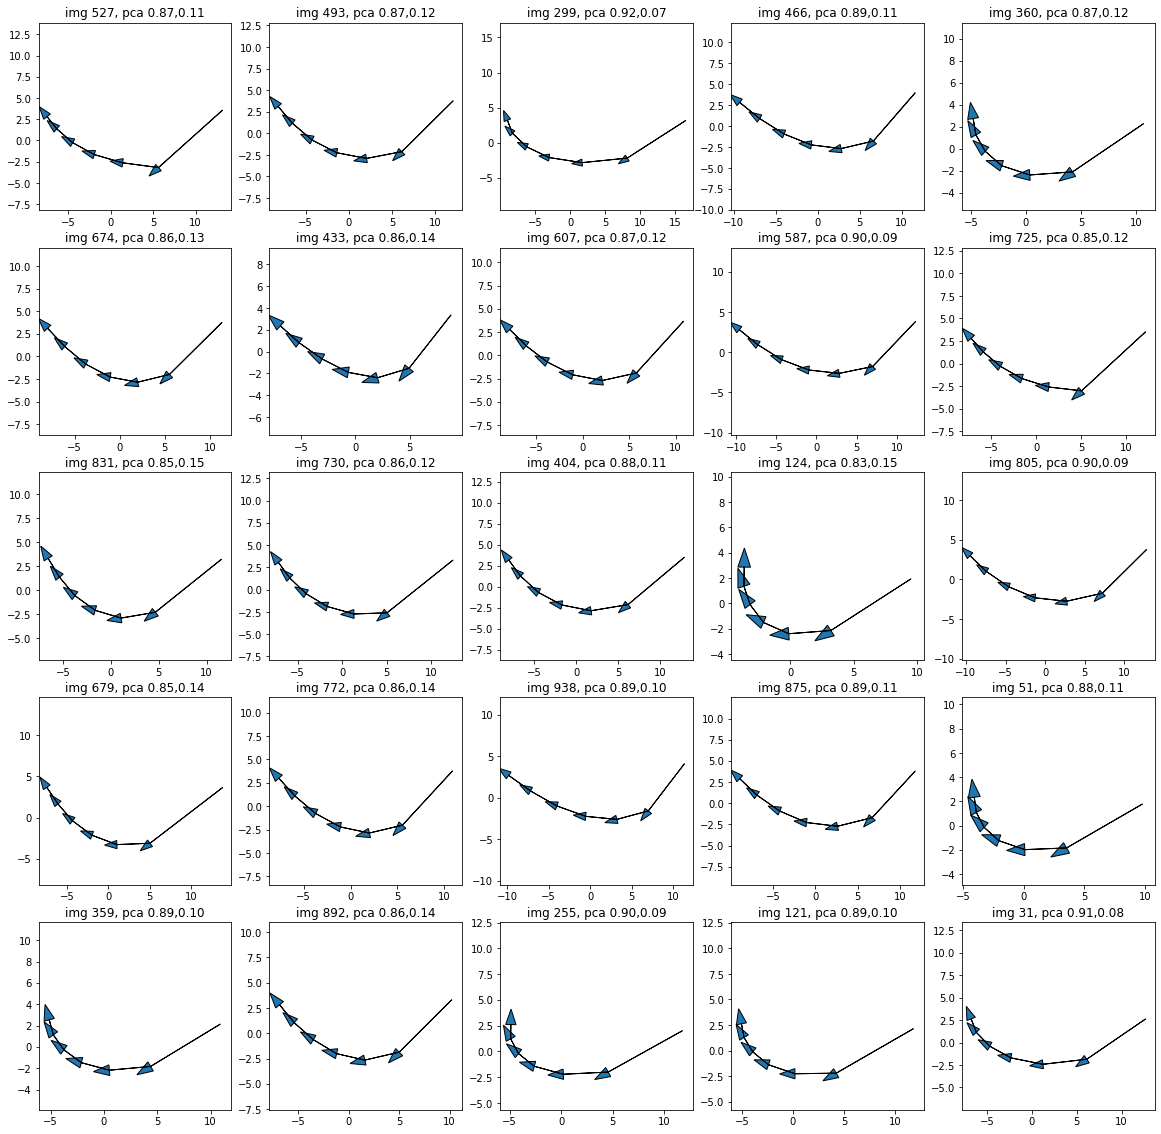

In [34]:
plot_25_graph_given_data(df_all_cp_to_study_sorted.iloc[-2], 2)